## Modifying a Simple MODFLOW 6 Model with Flopy


### Setup the Notebook Environment

In [1]:
import os

In [2]:
import sys
from tempfile import TemporaryDirectory

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import flopy

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.24.3
matplotlib version: 3.7.2
flopy version: 3.4.1


In [3]:
# Alternatively - create a folder to save the output files
workspace = os.path.join(".", "mf6Well")
try: 
    os.mkdir(workspace) 
    print("Directory '%s' created" %workspace) 
except OSError as error: 
    print(error)    

[WinError 183] Cannot create a file when that file already exists: '.\\mf6Well'


### Loading Flopy Model Objects



In [4]:
model_name = "well_00"
sim = flopy.mf6.MFSimulation.load(sim_name=model_name,sim_ws=workspace)
gwf = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package wel...
    loading package chd...
    loading package oc...
  loading solution package gwf_well_00...


In [5]:
gwf.name



'gwf_well_00'

In [6]:
gwf.get_package_list

<bound method ModelInterface.get_package_list of name = gwf_well_00
model_type = gwf6
version = mf6
model_relative_path = 

###################
Package dis
###################

package_name = dis
filename = gwf_well_00.dis
package_type = dis
model_or_simulation_package = model
model_name = gwf_well_00


###################
Package ic
###################

package_name = ic
filename = gwf_well_00.ic
package_type = ic
model_or_simulation_package = model
model_name = gwf_well_00


###################
Package npf
###################

package_name = npf
filename = gwf_well_00.npf
package_type = npf
model_or_simulation_package = model
model_name = gwf_well_00


###################
Package sto
###################

package_name = sto
filename = gwf_well_00.sto
package_type = sto
model_or_simulation_package = model
model_name = gwf_well_00


###################
Package wel
###################

package_name = wel
filename = gwf_well_00.wel
package_type = wel
model_or_simulation_package = model
mo

In [7]:
wel = gwf.get_package('WEL')

In [8]:
wel.stress_period_data

{internal}
(rec.array([((0, 7, 7), -600., 'well_00')],
          dtype=[('cellid', 'O'), ('q', '<f8'), ('boundname', 'O')]))

In [9]:
# Modify the pumping
new_stress_period_data = {}
new_stress_period_data[0] = [0, 7, 7,-700.,'well_00']

wel.stress_period_data = new_stress_period_data

In [10]:
wel.stress_period_data

{internal}
(rec.array([((0, 7, 7), -700., 'well_00')],
          dtype=[('cellid', 'O'), ('q', '<f8'), ('boundname', 'O')]))

### Create the MODFLOW 6 Input Files and Run the Model

Once all the flopy objects are created, it is very easy to create all of the input files and run the model.

In [11]:
# Write the datasets
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package gwf_well_00...
  writing model gwf_well_00...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package wel...
    writing package chd...
    writing package oc...


In [12]:
# Print a list of the files that were created
# in workspace
print(os.listdir(workspace))

['gwf_well_00.cbb', 'gwf_well_00.chd', 'gwf_well_00.dis', 'gwf_well_00.dis.grb', 'gwf_well_00.hds', 'gwf_well_00.ic', 'gwf_well_00.lst', 'gwf_well_00.nam', 'gwf_well_00.npf', 'gwf_well_00.oc', 'gwf_well_00.sto', 'gwf_well_00.wel', 'mfsim.lst', 'mfsim.nam', 'well_00.ims', 'well_00.tdis']


### Run the Simulation

We can also run the simulation from the notebook, but only if the MODFLOW 6 executable is available.  The executable can be made available by putting the executable in a folder that is listed in the system path variable.  Another option is to just put a copy of the executable in the simulation folder, though this should generally be avoided.  A final option is to provide a full path to the executable when the simulation is constructed.  This would be done by specifying exe_name with the full path.

In [13]:
# Run the simulation
success, buff = sim.run_simulation(silent=True, report=True)
if success:
    for line in buff:
        print(line)
else:
    raise ValueError("Failed to run.")

                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jun 28 2023 18:41:13 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthoriz

### Post-Process Head Results

Post-processing MODFLOW 6 results is still a work in progress.  There aren't any Flopy plotting functions built in yet, like they are for other MODFLOW versions.  So we need to plot the results using general Flopy capabilities.  We can also use some of the Flopy ModelMap capabilities for MODFLOW 6, but in order to do so, we need to manually create a SpatialReference object, that is needed for the plotting.  Examples of both approaches are shown below.

First, a link to the heads file is created with `HeadFile`. The link can then be accessed with the `get_data` function, by specifying, in this case, the step number and period number for which we want to retrieve data. A three-dimensional array is returned of size `nlay, nrow, ncol`. Matplotlib contouring functions are used to make contours of the layers or a cross-section.

In [15]:
# Read the binary head file and plot the results
# We can use the existing Flopy HeadFile class because
# the format of the headfile for MODFLOW 6 is the same
# as for previous MODFLOW verions

headfile = "{}.hds".format(gwf.name)
budgetfile = "{}.cbb".format(gwf.name)

fname = os.path.join(workspace, headfile)
hds = flopy.utils.binaryfile.HeadFile(fname)
h = hds.get_alldata()

h.shape


(19, 1, 15, 15)

(0.0, 15.0, 0.0, 15.0)

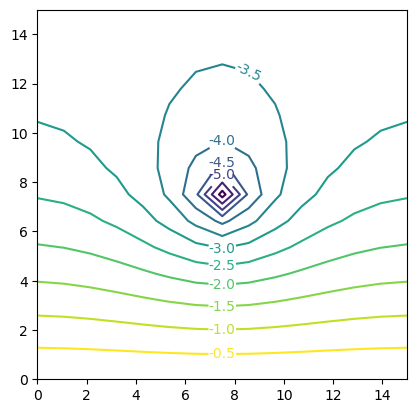

In [18]:
nrow, ncol = h.shape[2], h.shape[3]
x = y = np.linspace(0, nrow, ncol)
min_hd = round(np.min(h[-1, 0,:, :]),0)
c = plt.contour(x, y, h[-1, 0,:, :], np.arange(min_hd, 0., 0.5))
plt.clabel(c, fmt="%1.1f")
plt.axis("scaled")

In [29]:
dis = gwf.get_package('DIS')

dis

package_name = dis
filename = gwf_well_00.dis
package_type = dis
model_or_simulation_package = model
model_name = gwf_well_00

Block options
--------------------
length_units
{internal}
('meters')


Block dimensions
--------------------
nlay
{internal}
(1)

nrow
{internal}
(15)

ncol
{internal}
(15)


Block griddata
--------------------
delr
{constant 1000.0}

delc
{constant 1000.0}

top
{constant 0.0}

botm
{constant -100.0}



### Post-Process Flows

MODFLOW 6 writes a binary grid file, which contains information about the model grid.  MODFLOW 6 also writes a binary budget file, which contains flow information.  Both of these files can be read using Flopy capabilities.  The MfGrdFile class in Flopy can be used to read the binary grid file.  The CellBudgetFile class in Flopy can be used to read the binary budget file written by MODFLOW 6.

In [ ]:
# read the binary grid file
fname = os.path.join(workspace, "{}.dis.grb".format(gwf_name))
bgf = flopy.mf6.utils.MfGrdFile(fname)

# data read from the binary grid file is stored in a dictionary
bgf._datadict

In [ ]:
# read the cell budget file
fname = os.path.join(workspace, "{}.cbb".format(gwf_name))
cbb = flopy.utils.CellBudgetFile(fname, precision="double")
cbb.list_records()

flowja = cbb.get_data(text="FLOW-JA-FACE")[0][0, 0, :]
chdflow = cbb.get_data(text="CHD")[0]

In [ ]:
# By having the ia and ja arrays and the flow-ja-face we can look at
# the flows for any cell and process them in the follow manner.
k = 0
i = 7
j = 7
celln = k * nrow * ncol + i * nrow + j
ia, ja = bgf.ia, bgf.ja

print("Printing flows for cell {}".format(celln))
for ipos in range(ia[celln] + 1, ia[celln + 1]):
    cellm = ja[ipos]
    print("Cell {} flow with cell {} is {}".format(celln, cellm, flowja[ipos]))
